In [1]:
import pandas as pd
import numpy as np

try:
    # --- Step 1: Load Your ORIGINAL 'heart2.csv' File ---
    df = pd.read_csv('heart_model_ready_final.csv')
    print("Step 1: Successfully loaded 'heart2.csv'.")

    # --- Step 2: Handle Anomalies (0 values) ---
    # Replace 0 in RestingBP and Cholesterol with the median of the column
    # Median is better than mean for skewed data or data with outliers.
    
    # Calculate medians BEFORE changing the 0s
    median_bp = df[df['RestingBP'] > 0]['RestingBP'].median()
    median_chol = df[df['Cholesterol'] > 0]['Cholesterol'].median()

    df['RestingBP'] = df['RestingBP'].replace(0, median_bp)
    df['Cholesterol'] = df['Cholesterol'].replace(0, median_chol)
    print("Step 2: Replaced 0 values in 'RestingBP' and 'Cholesterol' with their respective medians.")

    # --- Step 3: Handle Negative Oldpeak Values ---
    # Capping negative values at 0 is a standard and safe approach.
    df['Oldpeak'] = np.clip(df['Oldpeak'], 0, None) # Sets a minimum of 0, no maximum
    print("Step 3: Corrected negative 'Oldpeak' values by setting them to 0.")

    # --- Step 4: Engineer the HR and HRV Features (Final Version) ---
    # Remove original HR/HRV columns if they exist
    cols_to_drop = ['HR', 'HRV']
    if any(col in df.columns for col in cols_to_drop):
        df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    # Calculate RestingHR
    df['RestingHR'] = 60 + (220 - df['Age'] - df['MaxHR']) * 0.5
    df['RestingHR'] = np.clip(df['RestingHR'], 50, 100).round(0).astype(int)

    # Calculate the final, guaranteed HRV formula
    df['HRV'] = 110 - df['Age']
    df['HRV'] = np.clip(df['HRV'], 20, 120).round(2)
    print("Step 4: Engineered the final 'RestingHR' and 'HRV' columns.")
    
    # --- Step 5: Save the Final, FULLY CLEANED Dataset ---
    output_filename = 'heart_fully_cleaned_and_engineered.csv'
    df.to_csv(output_filename, index=False)
    print("\n" + "="*50)
    print(f"SUCCESS! Your final, fully cleaned dataset is saved as '{output_filename}'")
    print("This dataset is now robust and ready for modeling.")
    print("="*50 + "\n")

    # --- Step 6: Display a preview ---
    print("Here is a preview of your final data:")
    print(df[['RestingBP', 'Cholesterol', 'Oldpeak', 'HRV']].head())

except FileNotFoundError:
    print("CRITICAL ERROR: Could not find 'heart2.csv'. Please ensure it is uploaded.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Step 1: Successfully loaded 'heart2.csv'.
Step 2: Replaced 0 values in 'RestingBP' and 'Cholesterol' with their respective medians.
Step 3: Corrected negative 'Oldpeak' values by setting them to 0.
Step 4: Engineered the final 'RestingHR' and 'HRV' columns.

SUCCESS! Your final, fully cleaned dataset is saved as 'heart_fully_cleaned_and_engineered.csv'
This dataset is now robust and ready for modeling.

Here is a preview of your final data:
   RestingBP  Cholesterol  Oldpeak  HRV
0        140          289      0.0   70
1        160          180      1.0   61
2        130          283      0.0   73
3        138          214      1.5   62
4        150          195      0.0   56


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Import all the classifiers you want to test
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

try:
    # --- Step 1: Load Your Fully Cleaned and Engineered Dataset ---
    df = pd.read_csv('heart_fully_cleaned_and_engineered.csv')
    print("--- Step 1: Successfully loaded the final clean dataset. ---\n")

    # --- Step 2: Define Features (X) and Target (y) ---
    X = df.drop('HeartDisease', axis=1)
    y = df['HeartDisease']

    # --- Step 3: Identify Categorical and Numeric Columns for Preprocessing ---
    categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
    numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'RestingHR', 'HRV']

    # --- Step 4: Split Data into Training and Testing Sets ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print("--- Step 4: Data split into 80% training and 20% testing sets. ---\n")

    # --- Step 5: Create a Preprocessing Pipeline ---
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    # --- Step 6: Define the List of Classifiers to Compare ---
    classifiers = {
        "Logistic Regression": LogisticRegression(random_state=42),
        "Gaussian Naive Bayes": GaussianNB(),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Support Vector Machine (SVM)": SVC(random_state=42),
        "K-Nearest Neighbors (KNN)": KNeighborsClassifier()
    }

    # --- Step 7: Train, Test, and Compare Each Model ---
    results = {}
    print("--- Step 7: Training and evaluating models... ---\n")
    
    for model_name, classifier in classifiers.items():
        # Create a full pipeline with preprocessing and the classifier
        model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                        ('classifier', classifier)])
        
        # Train the model
        model_pipeline.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = model_pipeline.predict(X_test)
        
        # Calculate accuracy and store the result
        accuracy = accuracy_score(y_test, y_pred)
        results[model_name] = accuracy
        print(f"Accuracy for {model_name}: {accuracy:.2%}")

    # --- Step 8: Announce the Best Model ---
    best_model_name = max(results, key=results.get)
    best_accuracy = results[best_model_name]

    print("\n" + "="*50)
    print("          MODEL COMPARISON RESULTS")
    print("="*50)
    print(f"\nThe best performing model is: {best_model_name}")
    print(f"It achieved an accuracy of: {best_accuracy:.2%}")
    print("="*50)

except FileNotFoundError:
    print("Error: Could not find 'heart_fully_cleaned_and_engineered.csv'. Please ensure it's available.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Step 1: Successfully loaded the final clean dataset. ---

--- Step 4: Data split into 80% training and 20% testing sets. ---

--- Step 7: Training and evaluating models... ---

Accuracy for Logistic Regression: 88.59%
Accuracy for Gaussian Naive Bayes: 85.87%
Accuracy for Decision Tree: 76.63%
Accuracy for Random Forest: 88.04%
Accuracy for Support Vector Machine (SVM): 88.04%
Accuracy for K-Nearest Neighbors (KNN): 86.41%

          MODEL COMPARISON RESULTS

The best performing model is: Logistic Regression
It achieved an accuracy of: 88.59%


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

try:
    # --- Step 1: Load Your Fully Cleaned and Engineered Dataset ---
    df = pd.read_csv('heart_fully_cleaned_and_engineered.csv')
    print("--- Step 1: Successfully loaded the final clean dataset. ---\n")

    # --- Step 2: Define Features (X) and Target (y) ---
    X = df.drop('HeartDisease', axis=1)
    y = df['HeartDisease']

    # --- Step 3: Identify Column Types and Split Data ---
    categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
    numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'RestingHR', 'HRV']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # --- Step 4: Create the Preprocessing Pipeline ---
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

    # --- Step 5: Hyperparameter Tuning for Logistic Regression ---
    print("="*50)
    print("Tuning Hyperparameters for Logistic Regression...")
    print("="*50)
    
    # Define the model pipeline
    lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', LogisticRegression(random_state=42, solver='liblinear'))])
    
    # Define the hyperparameter grid
    lr_param_grid = {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2']
    }
    
    # Set up RandomizedSearchCV with 5-fold cross-validation
    lr_search = RandomizedSearchCV(lr_pipeline, param_distributions=lr_param_grid, n_iter=10, cv=StratifiedKFold(5), random_state=42, n_jobs=-1)
    
    # Run the search
    lr_search.fit(X_train, y_train)
    
    print(f"Best parameters found: {lr_search.best_params_}")
    print(f"Best cross-validated accuracy: {lr_search.best_score_:.2%}\n")


    # --- Step 6: Hyperparameter Tuning for Random Forest ---
    print("="*50)
    print("Tuning Hyperparameters for Random Forest...")
    print("="*50)

    # Define the model pipeline
    rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', RandomForestClassifier(random_state=42))])

    # Define the hyperparameter grid
    rf_param_grid = {
        'classifier__n_estimators': [100, 200, 300, 500],
        'classifier__max_depth': [5, 10, 20, 30, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    }

    # Set up RandomizedSearchCV
    rf_search = RandomizedSearchCV(rf_pipeline, param_distributions=rf_param_grid, n_iter=20, cv=StratifiedKFold(5), random_state=42, n_jobs=-1)
    
    # Run the search
    rf_search.fit(X_train, y_train)

    print(f"Best parameters found: {rf_search.best_params_}")
    print(f"Best cross-validated accuracy: {rf_search.best_score_:.2%}\n")


except FileNotFoundError:
    print("Error: Could not find 'heart_fully_cleaned_and_engineered.csv'. Please ensure it's available.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Step 1: Successfully loaded the final clean dataset. ---

Tuning Hyperparameters for Logistic Regression...
Best parameters found: {'classifier__penalty': 'l1', 'classifier__C': 0.1}
Best cross-validated accuracy: 85.42%

Tuning Hyperparameters for Random Forest...
Best parameters found: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 20}
Best cross-validated accuracy: 86.10%



--- Step 1: Loaded the final clean dataset. ---

--- Step 3: Defined the final model with its best hyperparameters. ---

--- Step 4: Final model training is complete! ---

          FINAL MODEL PERFORMANCE

Final Model Accuracy on the Test Set: 88.04%

Final Classification Report:
                precision    recall  f1-score   support

No Disease (0)       0.89      0.83      0.86        82
   Disease (1)       0.87      0.92      0.90       102

      accuracy                           0.88       184
     macro avg       0.88      0.88      0.88       184
  weighted avg       0.88      0.88      0.88       184


A visual Confusion Matrix for the final model has been saved as 'final_model_confusion_matrix.png'


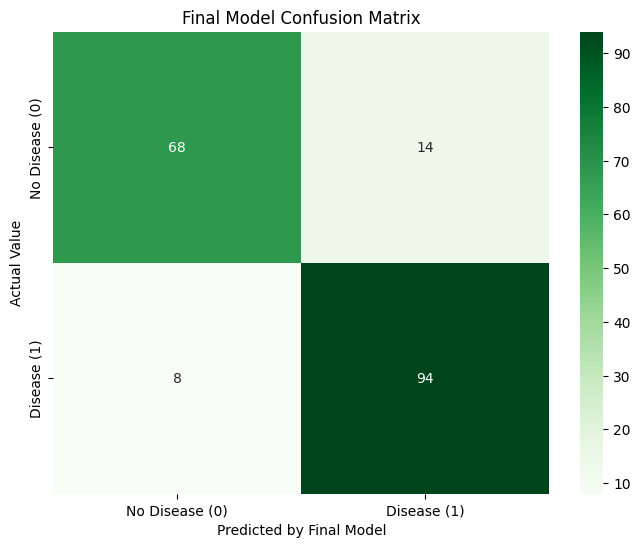

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

try:
    # --- Step 1: Load Your Fully Cleaned and Engineered Dataset ---
    df = pd.read_csv('heart_fully_cleaned_and_engineered.csv')
    print("--- Step 1: Loaded the final clean dataset. ---\n")

    # --- Step 2: Prepare Data (using the same steps as before for consistency) ---
    X = df.drop('HeartDisease', axis=1)
    y = df['HeartDisease']
    
    categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
    numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'RestingHR', 'HRV']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    # --- Step 3: Define the Final, Tuned Model ---
    # We are using RandomForestClassifier with the best parameters we found from the tuning step.
    final_model = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', RandomForestClassifier(
                                      n_estimators=200,
                                      min_samples_split=10,
                                      min_samples_leaf=2,
                                      max_depth=20,
                                      random_state=42
                                  ))])
    
    print("--- Step 3: Defined the final model with its best hyperparameters. ---\n")

    # --- Step 4: Train the Final Model on the ENTIRE Training Set ---
    final_model.fit(X_train, y_train)
    print("--- Step 4: Final model training is complete! ---\n")

    # --- Step 5: Evaluate the Final Model on the Test Set ---
    y_pred = final_model.predict(X_test)
    
    print("="*50)
    print("          FINAL MODEL PERFORMANCE")
    print("="*50)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nFinal Model Accuracy on the Test Set: {accuracy:.2%}\n")

    print("Final Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Disease (0)', 'Disease (1)']))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['No Disease (0)', 'Disease (1)'], yticklabels=['No Disease (0)', 'Disease (1)'])
    plt.xlabel('Predicted by Final Model')
    plt.ylabel('Actual Value')
    plt.title('Final Model Confusion Matrix')
    plt.savefig('final_model_confusion_matrix.png')
    print("\nA visual Confusion Matrix for the final model has been saved as 'final_model_confusion_matrix.png'")

except FileNotFoundError:
    print("Error: Could not find 'heart_fully_cleaned_and_engineered.csv'. Please ensure it's available.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [5]:
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

try:
    # --- Step 1: Load Your FULLY Cleaned and Engineered Dataset ---
    df = pd.read_csv('heart_fully_cleaned_and_engineered.csv')
    print("--- Step 1: Successfully loaded the final clean dataset. ---\n")

    # --- Step 2: Define the Full Dataset as X and y ---
    # We use the entire dataset for training the final deployable model.
    X = df.drop('HeartDisease', axis=1)
    y = df['HeartDisease']
    print("--- Step 2: Using the full dataset for final training. ---\n")

    # --- Step 3: Define the Preprocessing Pipeline ---
    # This must be the same pipeline used during testing.
    categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
    numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'RestingHR', 'HRV']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

    # --- Step 4: Define the Final, Tuned Model ---
    # We create the full pipeline with the best hyperparameters we found.
    final_model = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', RandomForestClassifier(
                                      n_estimators=200,
                                      min_samples_split=10,
                                      min_samples_leaf=2,
                                      max_depth=20,
                                      random_state=42
                                  ))])
    
    # --- Step 5: Train the Model on ALL Data ---
    final_model.fit(X, y)
    print("--- Step 5: Final model has been trained on the entire dataset! ---\n")

    # --- Step 6: Save the Trained Model to a File ---
    model_filename = 'heart_disease_model.joblib'
    joblib.dump(final_model, model_filename)
    
    print("="*50)
    print("          MODEL SAVED SUCCESSFULLY")
    print("="*50)
    print(f"\nYour trained model has been saved as '{model_filename}'")
    print("This file contains everything needed to make future predictions.")
    print("="*50)

except FileNotFoundError:
    print("Error: Could not find 'heart_fully_cleaned_and_engineered.csv'. Please ensure it's available.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Step 1: Successfully loaded the final clean dataset. ---

--- Step 2: Using the full dataset for final training. ---

--- Step 5: Final model has been trained on the entire dataset! ---

          MODEL SAVED SUCCESSFULLY

Your trained model has been saved as 'heart_disease_model.joblib'
This file contains everything needed to make future predictions.


In [6]:
import pandas as pd
import joblib

try:
    # --- Step 1: Load the Saved Model ---
    model_filename = 'heart_disease_model.joblib'
    loaded_model = joblib.load(model_filename)
    print(f"--- Successfully loaded the model from '{model_filename}' ---\n")

    # --- Step 2: Create New Patient Data ---
    # The data must have the same column names as the original dataset.
    new_patient_data = {
        'Age': [55],
        'Sex': ['M'],
        'ChestPainType': ['ASY'],
        'RestingBP': [145],
        'Cholesterol': [240],
        'FastingBS': [1],
        'RestingECG': ['Normal'],
        'MaxHR': [130],
        'Oldpeak': [1.5],
        'ST_Slope': ['Flat'],
        'ExerciseAngina': ['Y'],
        'RestingHR': [85],
        'HRV': [45.5]
    }
    
    # Convert the dictionary to a pandas DataFrame
    new_patient_df = pd.DataFrame(new_patient_data)
    print("--- Created data for a new patient: ---")
    print(new_patient_df)
    
    # --- Step 3: Use the Model to Make a Prediction ---
    # The .predict() method takes the DataFrame and returns the prediction.
    prediction = loaded_model.predict(new_patient_df)
    
    # The .predict_proba() method gives the probability for each class.
    prediction_proba = loaded_model.predict_proba(new_patient_df)

    print("\n" + "="*50)
    print("          PREDICTION RESULT")
    print("="*50)
    
    if prediction[0] == 1:
        print("\nModel Prediction: The patient is LIKELY to have heart disease.")
    else:
        print("\nModel Prediction: The patient is UNLIKELY to have heart disease.")
        
    print(f"\nPrediction Confidence:")
    print(f"   Probability of No Disease (0): {prediction_proba[0][0]:.2%}")
    print(f"   Probability of Disease (1):    {prediction_proba[0][1]:.2%}")
    print("="*50)

except FileNotFoundError:
    print(f"Error: Could not find the model file '{model_filename}'. Make sure you've run the first script to save it.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Successfully loaded the model from 'heart_disease_model.joblib' ---

--- Created data for a new patient: ---
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   55   M           ASY        145          240          1     Normal    130   

   Oldpeak ST_Slope ExerciseAngina  RestingHR   HRV  
0      1.5     Flat              Y         85  45.5  

          PREDICTION RESULT

Model Prediction: The patient is LIKELY to have heart disease.

Prediction Confidence:
   Probability of No Disease (0): 2.11%
   Probability of Disease (1):    97.89%


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

try:
    # --- Step 1: Load Your Fully Cleaned and Engineered Dataset ---
    df = pd.read_csv('heart_fully_cleaned_and_engineered.csv')
    print("--- Loaded the cleaned dataset. ---\n")

    # --- Step 2: Define Features and Target, and Split the Data ---
    X = df.drop('HeartDisease', axis=1)
    y = df['HeartDisease']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # --- Step 3: Manually Preprocess Data (The Robust Method) ---
    categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
    numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'RestingHR', 'HRV']
    
    # One-Hot Encode Categorical Features
    X_train_cat = pd.get_dummies(X_train[categorical_features], drop_first=True)
    X_test_cat = pd.get_dummies(X_test[categorical_features], drop_first=True)
    
    # Scale Numeric Features
    scaler = StandardScaler()
    X_train_num_scaled = scaler.fit_transform(X_train[numeric_features])
    X_test_num_scaled = scaler.transform(X_test[numeric_features])
    
    # Convert scaled numeric data back to DataFrames
    X_train_num_df = pd.DataFrame(X_train_num_scaled, columns=numeric_features, index=X_train.index)
    X_test_num_df = pd.DataFrame(X_test_num_scaled, columns=numeric_features, index=X_test.index)
    
    # Combine Processed Data
    X_train_final = pd.concat([X_train_num_df, X_train_cat], axis=1)
    X_test_final = pd.concat([X_test_num_df, X_test_cat], axis=1)
    
    # Align columns to ensure consistency
    X_test_final = X_test_final.reindex(columns=X_train_final.columns, fill_value=0)

    # --- Step 4: Save the Final, Processed Data ---
    X_train_final.to_csv('X_train_final.csv', index=False)
    X_test_final.to_csv('X_test_final.csv', index=False)
    y_train.to_csv('y_train.csv', index=False)
    y_test.to_csv('y_test.csv', index=False)
    
    print("="*50)
    print("SUCCESS! Your final, processed data has been saved.")
    print("You are now ready to run the final modeling and SHAP script.")
    print("="*50)

except FileNotFoundError:
    print("Error: Could not find 'heart_fully_cleaned_and_engineered.csv'. Please ensure it's available.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Loaded the cleaned dataset. ---

SUCCESS! Your final, processed data has been saved:
- X_train_final.csv
- X_test_final.csv
- y_train.csv
- y_test.csv

You are now ready to run the model training and SHAP script in the next cell.


--- Successfully loaded the final processed training data. ---

--- Final model trained. ---

--- Top 10 Most Important Features ---
                   Feature  Importance
21        cat__ST_Slope_Up    0.214292
20      cat__ST_Slope_Flat    0.131508
10  cat__ChestPainType_ASY    0.098577
5             num__Oldpeak    0.078371
4               num__MaxHR    0.061181
18   cat__ExerciseAngina_Y    0.055499
17   cat__ExerciseAngina_N    0.047630
6           num__RestingHR    0.044789
2         num__Cholesterol    0.040153
1           num__RestingBP    0.035768


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16884\1486093690.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')



SUCCESS! Your final, user-friendly feature importance plot has been saved as 'feature_importance_plot.png'


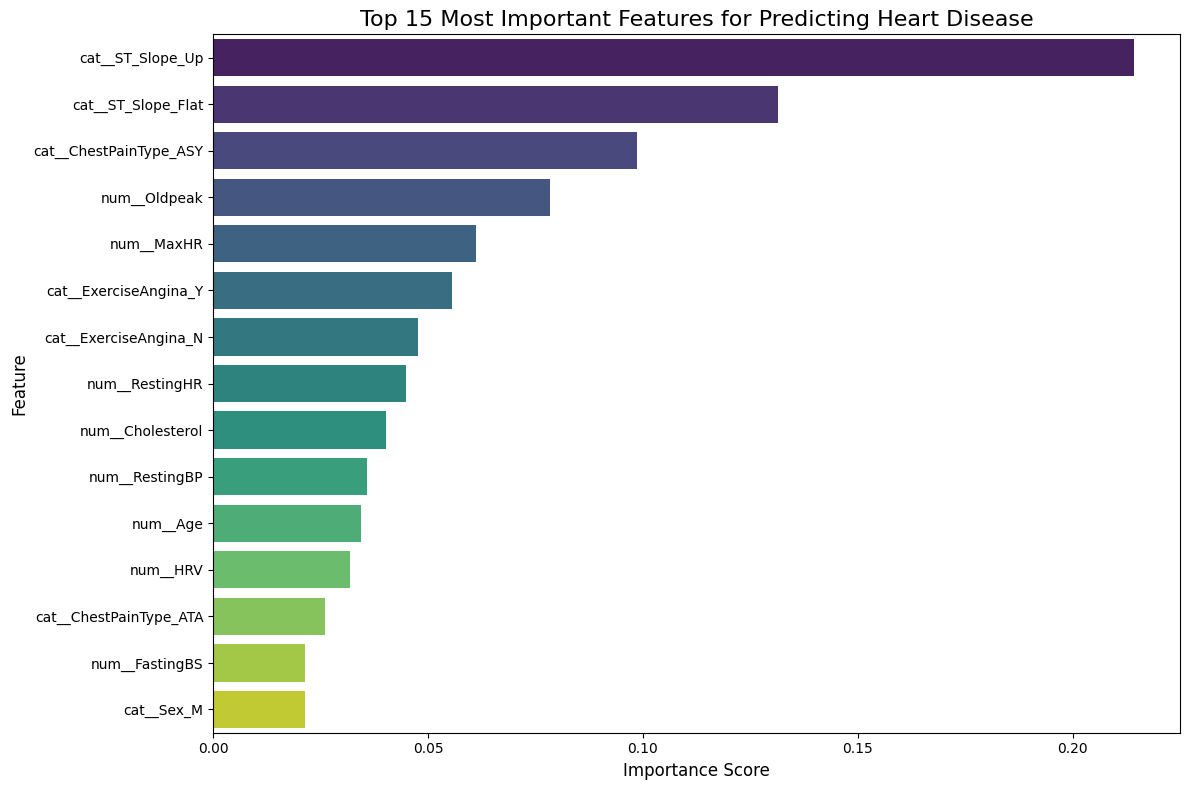

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

try:
    # --- Step 1: Load the FINAL PROCESSED Data ---
    X_train = pd.read_csv('X_train_final.csv')
    y_train = pd.read_csv('y_train.csv').squeeze()
    print("--- Successfully loaded the final processed training data. ---\n")

    # --- Step 2: Train the Final Model ---
    # We train the model to access its feature importances
    final_model = RandomForestClassifier(
        n_estimators=200, min_samples_split=10,
        min_samples_leaf=2, max_depth=20, random_state=42
    )
    final_model.fit(X_train, y_train)
    print("--- Final model trained. ---\n")

    # --- Step 3: Extract and Rank Feature Importances ---
    # The .feature_importances_ attribute contains the importance score for each feature.
    importances = final_model.feature_importances_
    
    # Create a DataFrame for easy sorting and plotting
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print("--- Top 10 Most Important Features ---")
    print(feature_importance_df.head(10))
    
    # --- Step 4: Generate and Save the Bar Plot ---
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
    
    plt.title('Top 15 Most Important Features for Predicting Heart Disease', fontsize=16)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    
    # Save the plot
    output_filename = 'feature_importance_plot.png'
    plt.savefig(output_filename, dpi=150)
    print(f"\nSUCCESS! Your final, user-friendly feature importance plot has been saved as '{output_filename}'")

except FileNotFoundError:
    print("Error: Could not find the final processed data files (e.g., 'X_train_final.csv'). Please run the preprocessing script first.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Step 1: Defined user input data. ---

--- Step 2: Identified the top NUMERIC features for visualization: ['Oldpeak', 'MaxHR', 'RestingHR', 'Cholesterol', 'RestingBP'] ---

--- Step 4: SUCCESS! Your personalized profile plot has been saved as 'user_profile_plot.png' ---


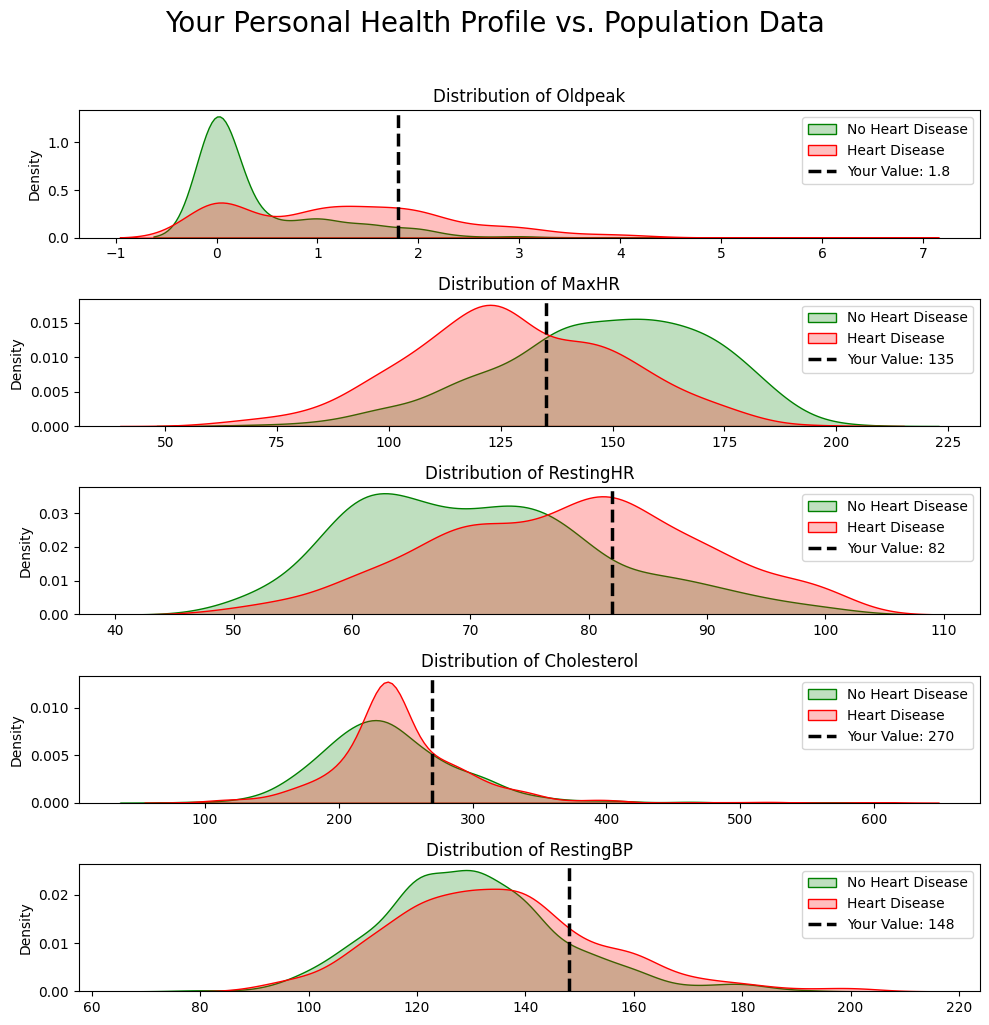

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

try:
    # --- Step 1: Define the User's Input Data ---
    user_input = {
        'Age': 58,
        'RestingBP': 148,
        'Cholesterol': 270,
        'MaxHR': 135,
        'Oldpeak': 1.8,
        'HRV': 52.0,
        'RestingHR': 82,
        'Sex': 'M',
        'ChestPainType': 'ASY',
        'FastingBS': 1,
        'RestingECG': 'ST',
        'ExerciseAngina': 'Y',
        'ST_Slope': 'Flat'
    }
    print("--- Step 1: Defined user input data. ---\n")

    # --- Step 2: Load Data and Find Top NUMERIC Features ---
    df = pd.read_csv('heart_fully_cleaned_and_engineered.csv')
    X_full = df.drop('HeartDisease', axis=1)
    y_full = df['HeartDisease']
    
    # Encode the full dataset to train a model
    X_encoded = pd.get_dummies(X_full, drop_first=True)
    
    model = RandomForestClassifier(
        n_estimators=200, min_samples_split=10,
        min_samples_leaf=2, max_depth=20, random_state=42
    )
    model.fit(X_encoded, y_full)
    
    # Get all feature importances
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X_encoded.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # ** THE FIX IS HERE **
    # We will only select the top features that are NUMERIC
    all_numeric_features = X_full.select_dtypes(include=np.number).columns.tolist()
    
    # Filter the importance dataframe to only include original numeric features
    top_numeric_features_df = feature_importance_df[feature_importance_df['Feature'].isin(all_numeric_features)]
    
    # Get the top 5 most important numeric features
    top_features_to_plot = top_numeric_features_df['Feature'].head(5).tolist()
    
    print(f"--- Step 2: Identified the top NUMERIC features for visualization: {top_features_to_plot} ---\n")

    # --- Step 3: Create the Visualization ---
    df_disease = df[df['HeartDisease'] == 1]
    df_no_disease = df[df['HeartDisease'] == 0]

    fig, axes = plt.subplots(len(top_features_to_plot), 1, figsize=(10, 10))
    fig.suptitle('Your Personal Health Profile vs. Population Data', fontsize=20, y=1.02)

    for i, feature in enumerate(top_features_to_plot):
        ax = axes[i]
        
        # Plot the distributions
        sns.kdeplot(df_no_disease[feature], ax=ax, label='No Heart Disease', color='green', fill=True)
        sns.kdeplot(df_disease[feature], ax=ax, label='Heart Disease', color='red', fill=True)
        
        # Add a vertical line for the user's input
        user_value = user_input[feature]
        ax.axvline(user_value, color='black', linestyle='--', linewidth=2.5, label=f'Your Value: {user_value}')
        
        ax.set_title(f'Distribution of {feature}', fontsize=12)
        ax.set_xlabel('')
        ax.set_ylabel('Density')
        ax.legend()

    plt.tight_layout()
    
    # --- Step 4: Save the Plot ---
    output_filename = 'user_profile_plot.png'
    plt.savefig(output_filename, dpi=150, bbox_inches='tight')
    print(f"--- Step 4: SUCCESS! Your personalized profile plot has been saved as '{output_filename}' ---")

except FileNotFoundError:
    print("Error: Could not find 'heart_fully_cleaned_and_engineered.csv'. Please ensure it's available.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")